## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models I
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, any figures you find useful, together with your answers.
* Please submit your report as a single PDF file, named according to: `name1_name2_name3_LabLinearModelsI.pdf`
* We recommend working in a group of 4–5 students (max 6); the report does not have to be submitted by every group member -- one submission per group is sufficient.

In [3]:
%matplotlib widget

# Imports
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.regression.linear_model import yule_walker

from scipy.signal import lfilter

# File paths
fbci = os.path.join(os.getcwd(), 'data', 'bci.json')
fafs = os.path.join(os.getcwd(), 'data', 'AF_sync.dat')
fspc = os.path.join(os.getcwd(), 'data', 'speech.dat')
fbld = os.path.join(os.getcwd(), 'data', 'blood.dat')

### Experiment 1: classifying EEG signals
The file `/data/bci.mat` contains two data matrices, `left_hand` and `right_foot`, from a brain-computer interface (BCI) experiment. Each column in these matrices corresponds to a 2-second electroencephalography (EEG) recording (sampling frequency of 128 Hz) from the same electrode. The recordings in `left_hand` (respectively `right_foot`) were performed while the subject imagines a movement of the left hand (resp. right foot). The goal of the BCI experiment is to be able to “guess” what is being imagined based on the EEG signals alone.

We start by importing the signals (and removing their averages to better approximate our AR models):

In [4]:
with open(fbci, 'r') as f:
    jc = json.load(f)

eeg_lh = np.array(jc['left_hand'])
eeg_rf = np.array(jc['right_foot'])

eeg_lh -= np.mean(eeg_lh, axis=0, keepdims=True)
eeg_rf -= np.mean(eeg_rf, axis=0, keepdims=True)

#### AR model order
A useful first step to look for structure in the signals is estimating the AR model order of each signal. We define a function `ar_order` to fit models of different orders, obtain the model noise variance, and apply a specific criterion:

In [5]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), mdl, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 1.1.** What is the name of the criterion being applied in the function `ar_order` implemented above? How would you change the code to apply the Akaike Information Criterion (AIC) instead?

**Answer 1.1.** 
The criterion used in the `ar_order` function is the Minimum Description Length (MDL) criterion.  
To apply the Akaike Information Criterion (AIC) instead, the following modification should be made:
Replace  
`c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)`  
with  
`c[k] = nx * np.log(sg2) + 2 * (n+1)`

Let's look at the order estimate for an example signal, in a reasonable range up 20:

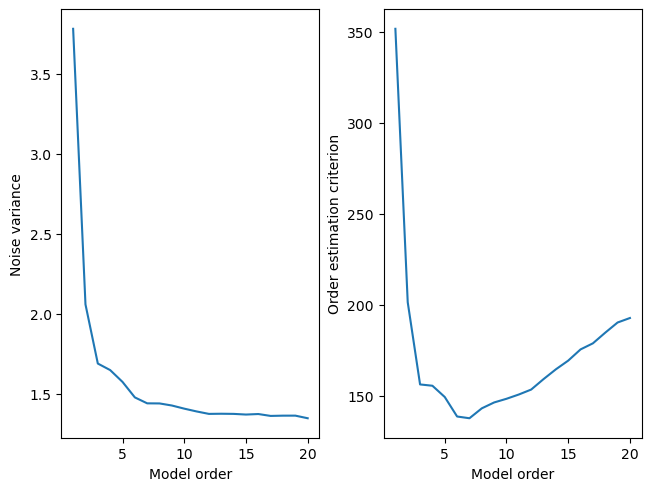

In [23]:
nmax = 20
_, s, c = ar_order(eeg_lh[:,1], nmax)

fig = plt.figure(constrained_layout=True)
n = np.arange(1, nmax+1)
plt.subplot(1,2,1)
plt.plot(n, s)
plt.xlabel('Model order')
plt.ylabel('Noise variance')
plt.subplot(1,2,2)
plt.plot(n, c)
plt.xlabel('Model order')
plt.ylabel('Order estimation criterion')
plt.show()

In [7]:
%matplotlib inline

**Question 1.2.** Do the two curves obtained for this example signal behave as we would expect? What are their most important characteristics?

**Answer 1.2.** 
Yes, the two curves behave as expected. The noise variance curve decreases as the model order increases, since higher-order models can fit the data better and thus reduce the residual error. However, the order estimation criterion (MDL) curve typically decreases at first and then reaches a minimum, after which it increases or flattens. This is because the criterion penalizes model complexity, so after a certain point, increasing the order does not sufficiently reduce the noise variance to justify the added complexity. The most important characteristics are the initial decrease in both curves and the presence of a minimum in the criterion curve, which indicates the optimal model order.

We can now estimate and print the optimal model order for every signal of each condition:

In [8]:
nmax = 10

print("\nLeft hand :", end="")
for k in range(eeg_lh.shape[1]):
    n, _, _ = ar_order(eeg_lh[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("")

print("Right foot:", end="")
for k in range(eeg_rf.shape[1]):
    n, _, _ = ar_order(eeg_rf[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("\n")


Left hand :  07  07  03  09
Right foot:  04  04  04  03



**Question 1.3.** Based on these AR order estimates, is there already a difference between the two categories overall? And if we wish to perform AR model estimation using a common choice of model order for all signals, which value should be chosen, and why?

**Answer 1.3.** 

Yes, there is already a noticeable difference between the two categories.  
The AR orders for the left-hand are generally higher and more variable.  
While the AR orders for the right foot are generally lower and more consistent.  

This suggests that the left-hand signals are more complex and contain richer dynamics, requiring higher-order models to capture their structure.

If we wish to use a common AR model order for all signals, we should select an order that is large enough to model the most complex signals but not excessively high to avoid overfitting.

We could choose AR order = 7

This captures the complexity of the left-hand signals (which go up to 9), is not too large for the right-foot signals, and ensures consistency and comparability between all signals.

#### Movement prediction
We now look at the resulting AR coefficients when choosing a model order of `3`:

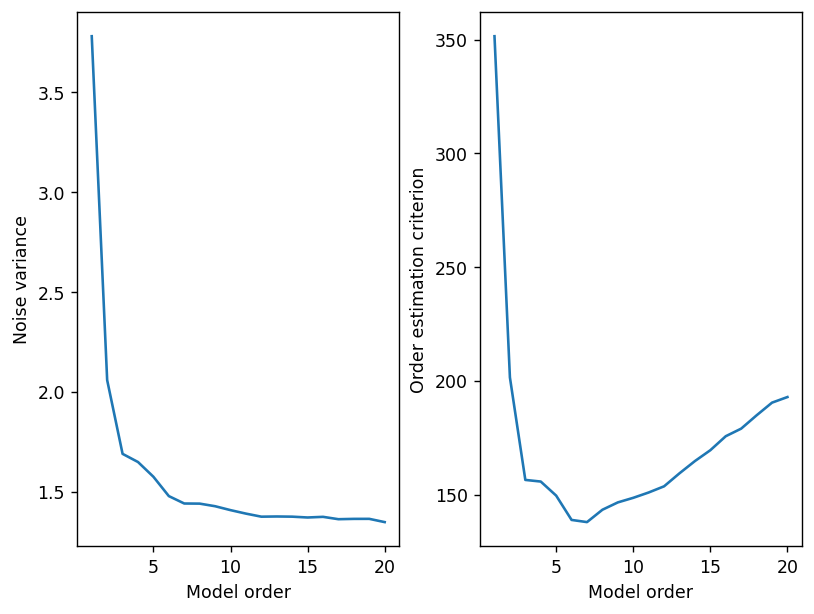

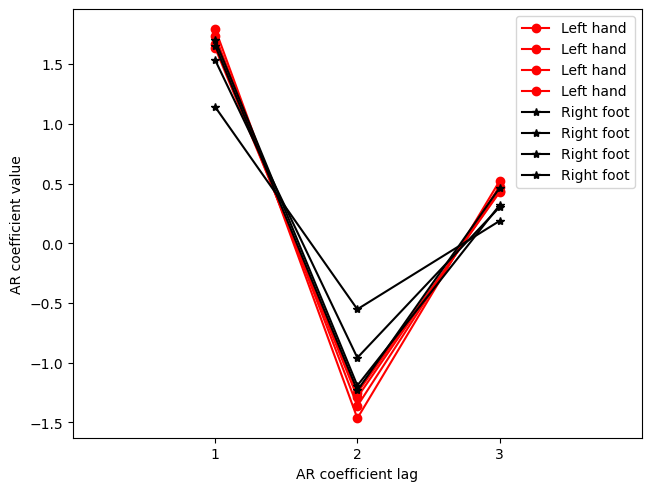

In [9]:
n = 3

fig = plt.figure(constrained_layout=True)

for k in range(eeg_lh.shape[1]):
    ar_model = AutoReg(eeg_lh[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,4), ar_model_fit.params, 'ro-', label='Left hand')
    
for k in range(eeg_rf.shape[1]):
    ar_model = AutoReg(eeg_rf[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,4), ar_model_fit.params, 'k*-', label='Right foot')
    
plt.legend()
plt.xticks(ticks=(1,2,3))
plt.xlabel('AR coefficient lag')
plt.ylabel('AR coefficient value')
plt.xlim(0,4)

plt.show()

**Question 1.4.** On which coefficients is the separation between categories most promising?

**Answer 1.4.**

The separation between the two categories (left hand vs right foot) appears most promising on the second AR coefficient (lag = 2).  

At lag 2, the left-hand signals show more negative coefficient values, while the right-foot signals have higher (less negative) values.  
This creates a clearer distinction between the two groups compared to lags 1 and 3, where their values overlap more.

### Experiment 2: AR model evolution over time
Real-life physiological signals can often vary substantially (and meaningfully) throughout a recording. It’s usually good practice to have a look at the data before trying to apply models. Consider the signal in `AF_sync.dat` – a recording of ECG atrial activity during atrial fibrillation (sampling frequency of 50 Hz). We start by importing the signal:

In [10]:
with open(fafs, 'r') as f:
    txt = f.readlines()
    af_sync = np.array([float(s[:-1]) for s in txt])
    
af_sync -= np.mean(af_sync)

#### Changes across time
Let's plot the signal and consider its evolution over the course of the recording. At the start (until sample ~2000 approximately), the signal is moderately organized; then it becomes very organized until sample ~3000. This probably corresponds to a drastic reduction in the number of fibrillatory waves in the atrial tissue (flutter). In the last part of the recording, the fibrillation, and thus the signal, becomes very disorganized.

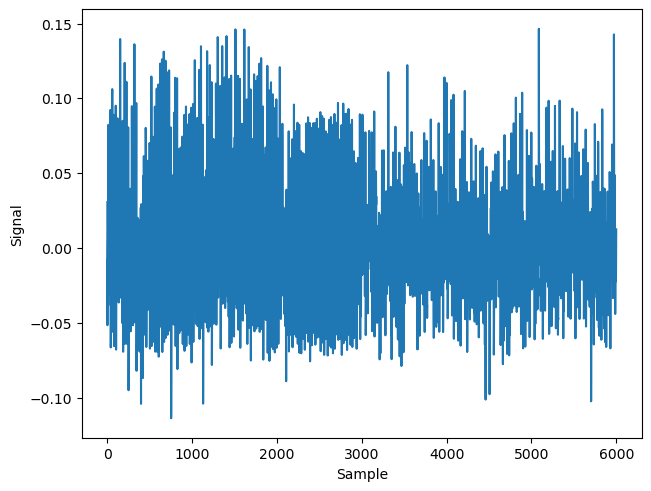

In [11]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

**Question 2.1.** The code below is intended to plot the signal again and mark the three periods described above, but it is not yet complete. Make the necessary modifications to show all three periods of interest.

**Answer 2.1.**

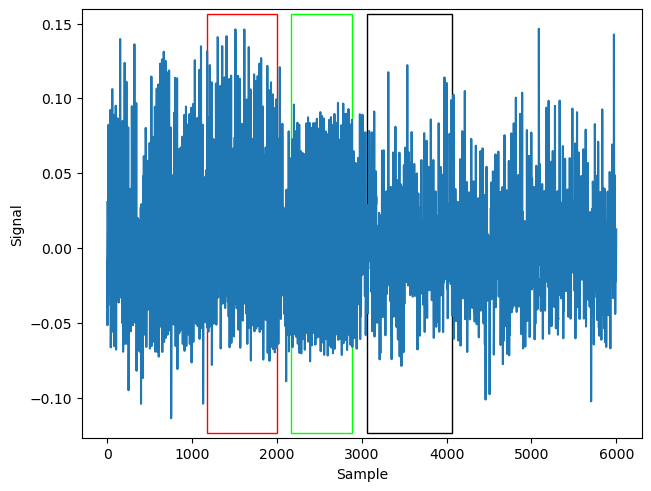

In [12]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')

segments = [[1170, 2000], [2170, 2890], [3060, 4060]]
eclr = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]

for i in range(len(segments)):
    ax.axvspan(segments[i][0], segments[i][1], ymin=0.01, ymax=0.99, ec=eclr[i], fill=False)

plt.show()

#### Adaptive modeling
The clearly different states in `af_sync`, which vary across time, can be studied and modeled more quantitatively using a sliding-window approach. We thereby consider a segmentation of the signal into 500-sample windows with 50% overlap. For each segment, we can then estimate (i) the signal variance, (ii) optimal AR order, and (iii) the AR coefficients & excitation variance, as follows:

In [13]:
nw = 500
nv = round(nw*0.50)
nt = len(af_sync)

kt = []
ki, kf = 0, nw

# Getting the border and middle indices for each segment
while True:
    kt.append([ki, round(0.5*(ki+kf)), kf])
    ki += nw - nv
    kf += nw - nv
    if kf > nt: break

nc = len(kt)
arv = np.zeros((nc,))
aro = np.zeros((nc,), dtype=int)
arr = np.zeros((nc,))
nmax = 40

# Modeling the signal for each segment
for kc in range(nc):
    
    ys = af_sync[kt[kc][0]:kt[kc][2]]

    arv[kc] = np.var(ys)
    aro[kc], _, _ = ar_order(ys, nmax)
    
    _, sigma = yule_walker(ys, order=int(aro[kc]), method="mle")
    arr[kc] = sigma**2 / arv[kc]

We can then plot together the time evolution of the raw signal, the signal variance, the AR order, and the ratio of excitation variance to signal variance.

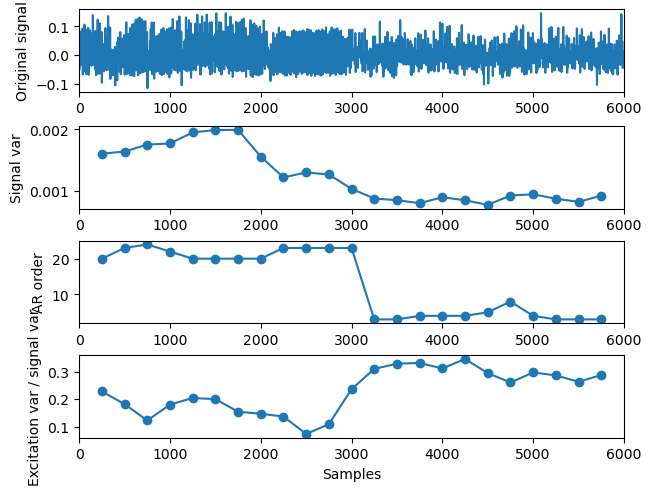

In [14]:
fig = plt.figure(constrained_layout=True)
t = np.array(kt)[:,1]

plt.subplot(4,1,1)
plt.plot(af_sync)
plt.ylabel('Original signal')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,2)
plt.plot(t, arv, 'o-')
plt.ylabel('Signal var')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,3)
plt.plot(t, aro, 'o-')
plt.ylabel('AR order')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,4)
plt.plot(t, arr, 'o-')
plt.ylabel('Excitation var / signal var')
plt.xlim(0, len(af_sync))
plt.xlabel('Samples')

plt.show()

**Question 2.2.** Interpret the time evolution of the parameters plotted above, and how they relate to the organization of the signal in the three afore-mentioned stages.

**Answer 2.2.** 

In the first stage the signal shows relatively high variance and the AR order is high, while the excitation-to-signal variance ratio sits in the middle. This indicates the signal is complex and requires a richer AR model to capture its temporal dependencies, but a nontrivial portion of the variance is still explained by the model (hence the mid-level excitation ratio). In the second stage (2000–3000) the signal variance drops slightly while the AR order remains high and the excitation-to-signal variance decreases a bit. This suggests that the rhythm becomes more regular so the same high-order model explains a bit more of the variance, even though overall amplitude changes are small. In the third stage the signal variance stays relatively low but the AR order falls sharply while the excitation-to-signal variance rises quickly. This shows that the predictable structure of the signal disappears so a low-order AR model suffices (since there is little consistent temporal correlation left). However most of the remaining variance is unexplained by the model which is reflected in the high excitation ratio. This matches the visual impression of the final stage where the singal becomes irregular and disorganized.

#### Signal stability and organization
Finally, another way of evaluating how organized a signal is, is by looking at its equivalent filter transfer function *H(z)* and the positioning of the corresponding poles. We can focus specifically on the three states defined previously in `segments`, as follows:

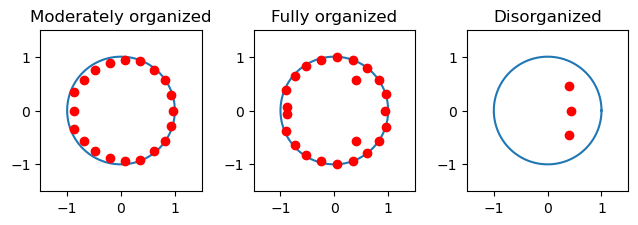

In [15]:
roots = []

for seg in segments:
    
    ys = af_sync[seg[0]:seg[1]]
    
    aro, _, _ = ar_order(ys, nmax)
    rho, _ = yule_walker(ys, order=int(aro), method="mle")
    
    rho = np.concatenate((-rho[::-1], np.array([1])), axis=0)
    roots.append(1 / np.roots(rho))

fig = plt.figure(constrained_layout=True)
t = np.linspace(0, 2*np.pi, 1000)
titles = ['Moderately organized', 'Fully organized', 'Disorganized']

for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(np.cos(t), np.sin(t))
    plt.plot(np.real(roots[k]), np.imag(roots[k]), 'ro')
    plt.axis('square')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title(titles[k])

plt.show()

And the proximity to the unit circle can be further summarized in terms of the average magnitude:

In [16]:
for kr in range(len(roots)):
    print(titles[kr] + ': {:.3f}'.format(np.mean(np.abs(roots[kr]))))

Moderately organized: 0.943
Fully organized: 0.951
Disorganized: 0.550


**Question 2.3.** Comment on how signal organization relates to pole location (proximity to the circle).

**Answer 2.3.** 

The moderately and fully organized segments have poles close to the unit circle with average magnitudes around 0.94–0.95, indicating strong and predictable oscillatory components in the signal. In contrast, the disorganized segment has poles closer to the origin with average magnitude 0.55, reflecting weak temporal correlations and high unpredictability. Essentially poles nearer to the unit circle result in a more structured and regular signal, whereas poles farther away lead to a more disordered signal.

### Experiment 3: recovering the excitation (whitening filter)
The signal in `speech.dat` corresponds to the spoken sound */a/*, sampled at 8 kHz. Used in language, we expect this signal to be clearly structured. We start by importing and plotting it:

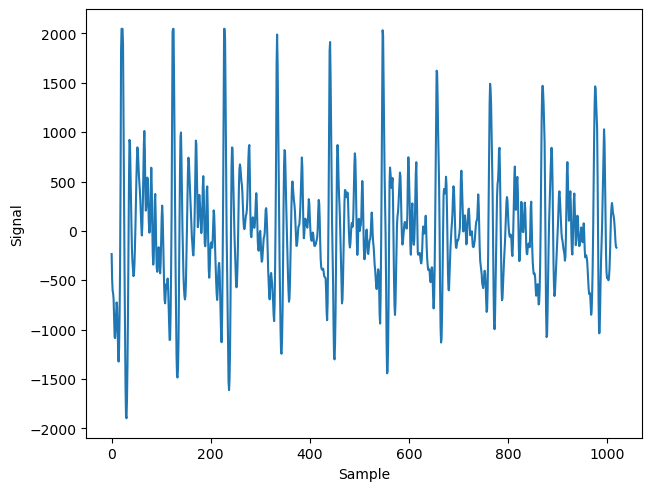

In [17]:
with open(fspc, 'r') as f:
    txt = f.readlines()
    speech = np.array([float(s[:-1]) for s in txt])

speech -= np.mean(speech)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(speech)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

Using the functions `ar_order` and `yule_walker` introduced before, we can estimate the optimal model order for this signal, and then the corresponsing model parameters:

In [18]:
aro1, _, _ = ar_order(speech, 40)
rho1, sgm1 = yule_walker(speech, order=int(aro1), method="mle")

#### The underlying excitation signal
In the framework of AR modeling, the excitation signal driving the observed speech signal can be estimated using a filtering step as follows:

In [19]:
exc1 = lfilter(np.concatenate(([1], -rho1), axis=0), [1], speech)

**Question 3.1.** Explain why the excitation can be estimated in this way.

**Answer 3.1.** `In autoregressive models, each sample of the signal is predicted from its past values and a random part (the excitation). By filtering the signal with the filtering step shown previously, the predictable part is removed, which leaves only the random component. Therefore, the excitation is what remains once the predictable part of the signal is removed.`

We can now visualize the estimated excitation signal:

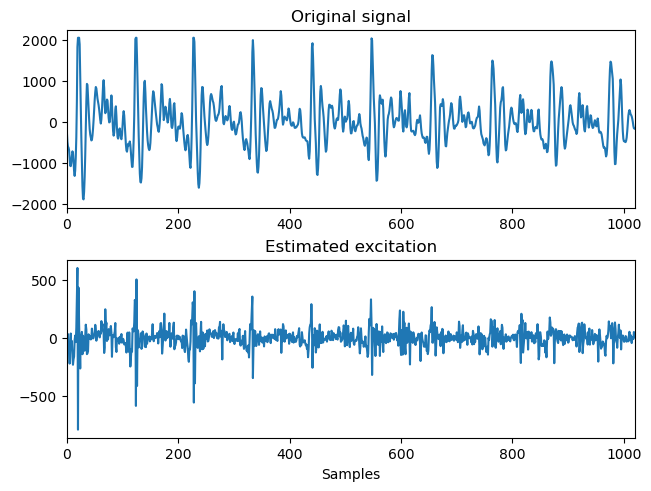

In [20]:
fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(speech)
plt.title('Original signal')
plt.xlim(0, len(speech))

plt.subplot(2,1,2)
plt.plot(exc1)
plt.title('Estimated excitation')
plt.xlim(0, len(speech))
plt.xlabel('Samples')
plt.show()

**Question 3.2.** Compare the excitation with the speech signal. Does the excitation look like white noise?

**Answer 3.2.** `The excitation looks slightly more random, therefore more like white noise, than the original signal, but it still has a repeating pulse pattern, especially towards the beginning. This can indicate that the AR model removed part  of the predictable signal, but that the estimated excitation is still not fully white.`

We can test more objectively whether the excitation is indeed similar to white noise by looking at its normalized autocorrelation, as follows:

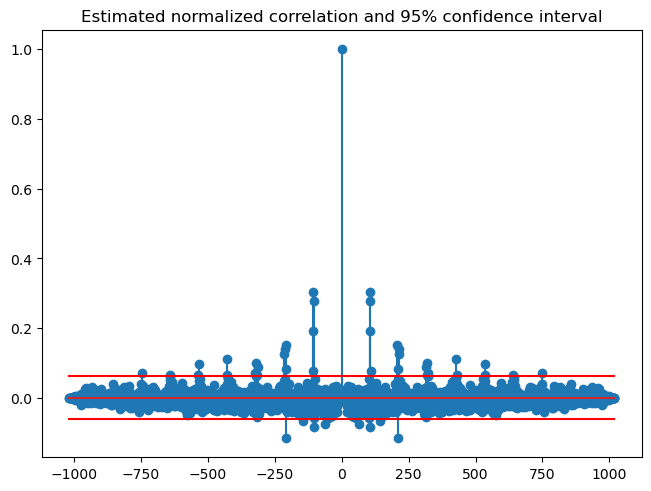

Proportion above 5% threshold: 0.023553


In [21]:
def test_white(x, Aff=0):
    """
    Computation of the ratio of normalized autocorrelation estimates 
    larger than a 5% threshold
    x: signal
    Aff: 0 no graphic display; 1 display
    """
    
    K = len(x)
    
    # Calculate the biased autocorrelation of the signal
    v = np.correlate(x, x, mode='full') / K
    # Note: K-1 is the index for zero lag
    
    thresh = 1.96 / np.sqrt(K)
    pc = np.sum(np.abs(v[K:] / v[K-1]) > thresh) / (K-1)
    
    if Aff == 1:
        fig = plt.figure(constrained_layout=True)
        ml = K-1 #min(30, K-1)
        lags = range(-ml, ml + 1)
        corr = v[K-1 - ml : K-1 + ml + 1] / v[K-1]
        plt.stem(lags, corr)
        plt.plot([-ml, ml], [+thresh, +thresh], 'r')
        plt.plot([-ml, ml], [-thresh, -thresh], 'r')
        plt.title('Estimated normalized correlation and 95% confidence interval')
        plt.show()

    return pc

print("Proportion above 5% threshold: {:f}".format(test_white(exc1, Aff=1)))

**Question 3.3.** What can we say based on this result?

**Answer 3.3.** `Since only 2.4% of the autocorrelation points fall outside of the confidence limits (above the 5% threshold), the excitation can be considered white. This means that the AR model removed most of the correlations, leaving a mostly random residual. It is also clearly visible in the correlation graph that the vast majority of points fall within the 95% confidence interval.`

We now consider a different example: a timeseries of daily blood systolic pressure recorded from a patient, stored in `blood.dat`:

In [ ]:
with open(fbld, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    blood = np.array([float(s[0]) for s in txt])

blood -= np.mean(blood)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(blood)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

: 

**Question 3.4.** Repeat the full analysis done for the speech signal (i.e. estimating AR order, model parameters, excitation signal, whiteness test). How does this excitation signal compare to that of the speech example?

In [ ]:
aro1, _, _ = ar_order(blood, 40)
rho1, sgm1 = yule_walker(blood, order=int(aro1), method="mle")

exc2 = lfilter(np.concatenate(([1], -rho1), axis=0), [1], blood)

In [ ]:
fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(blood)
plt.title('Original signal')
plt.xlim(0, len(blood))

plt.subplot(2,1,2)
plt.plot(exc2)
plt.title('Estimated excitation')
plt.xlim(0, len(blood))
plt.xlabel('Samples')
plt.show()

In [ ]:
print("Proportion above 5% threshold: {:f}".format(test_white(exc2, Aff=1)))

**Answer 3.4.** `Write your answer here`

### Have a good session, and don't hesitate to ask questions!